# Imports

In [1]:
import numpy as np
from scipy import special
from scipy import stats
import scipy
from scipy.ndimage.filters import gaussian_filter1d

# Manuscript code
from seroprevalence import *

# Figures
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from util import *

# Prevalence Inference (subpopulations)

When there are multiple subpopulations, and we have samples from each subpopulation, we can still infer prevalence from them.

## Serological Test Kit Parameters

Adjust as needed. We start with [sensingself.me/covid.php](sensingself.me/covid.php) IgG parameters of sensitivity 0.93 and specificity 0.975.  

In [2]:
sensitivity = 0.93
specificity = 0.975
# for convenience, swap to false positive fp and false negative fn.
fp = 1-specificity
fn = 1-sensitivity

# Input Data

In [20]:
# Here's where we can put the outcomes of a serological survey
# Note that we are going to make one of the bins totally empty!

# First, list the positive tests
posi = np.array([321, 123, 100, 10])
# Then, list the negative tests
negi = np.array([1234, 500, 375, 30])

# totals
ni = posi+negi

# Perform inference: draw from seroprevalence posterior

First, let's bring in the R code

In [21]:
import rpy2.robjects as ro
ro.r("source('seroprevalence.R')")
sprmhR = ro.globalenv['sample_posterior_r_mcmc_hyperR']

MCMC paramters

In [22]:
n_mcmc_samples = 10000
gamma0 = 150 

Sample!

In [23]:
# Note that we wrap the whole thing in the np.array() constructor
# This converts from R output into something we can bring back into the kitchen and cook with.
seroprevalence_samples = np.array(
    sprmhR(samps=n_mcmc_samples,
           posi=ro.vectors.FloatVector(posi.astype(float)),
           ni=ro.vectors.FloatVector(ni.astype(float)),
           se=sensitivity,
           sp=specificity,
           gam0=gamma0))
# For M subpopulations, the array that we just got back has M+2 columns. 
# Column 0 are posterior samples of gamma, the variance of the prior.
# Column 1 are posterior samples of r, the mean of the prior. 
# Columns 2-M are the posterior samples of the subpopulations.
subpop_prevs = seroprevalence_samples[:,2:]

# Plot Raw Serology Data

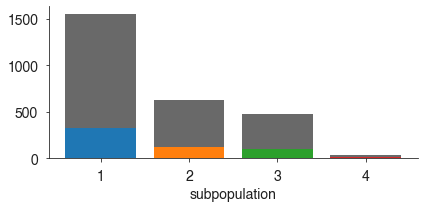

In [26]:
# Set up some axes
fig, ax = plt.subplots(nrows=1, ncols=1, 
                        figsize=(6,3),)

#1. Quick bar chart of the raw results
n_subpops = len(ni)
for i in range(n_subpops):
    ax.bar(i,posi[i],
           width=0.8,
  label='seropositive')
ax.bar(np.arange(n_subpops),ni-posi,
   bottom = posi,
  width=0.8,
   facecolor='dimgrey',)
ax.set_xlabel('subpopulation')
ax.set_xticks(np.arange(n_subpops))
ax.set_xticklabels(np.arange(1,n_subpops+1))


finalize(ax, ignoreLegend=True)
plt.tight_layout()

# Plot Results

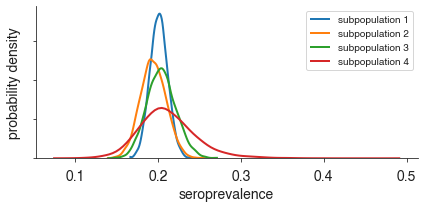

In [27]:
# Important stuff first: colors
dark_grey = [.3,.3,.3]
bin_width=0.6
lw=2
alph = 0.12

# Set up some axes
fig, ax = plt.subplots(nrows=1, ncols=1, 
                        figsize=(6,3),)

#1. Plot seroprevalence posteriors
n_subpops = len(ni)
for i in range(n_subpops):
    counts, bins = np.histogram(subpop_prevs[:,i],
                                bins=100,
                                density=True,)
    midpoints = (bins[:-1]+bins[1:])/2
    smooth_counts = gaussian_filter1d(counts, 2)
    ax.plot(midpoints,smooth_counts,
       lw=lw,
       label='subpopulation {}'.format(i+1))
    
ax.set_xlabel('seroprevalence')
ax.set_ylabel('probability density')
ax.set_yticklabels([])
ax.set_ylim(bottom=0)
ax.legend()

finalize(ax, ignoreLegend=True)
plt.tight_layout()

Finally, notice that the curve corresponding to subpopulation 4 has huge uncertainty, but has a similar mean to the other supopulations.  This is the effect of the Bayesian hierarchical model. Even with no data in that bin, the model assumes that its mean is unlikely to be too far from other bins.  USE WITH CAUTION!  This behavior is a feature, as it allows all the bins to learn from each other, while also allowing them to show their true heterogeneity.  On the other hand, if the unsampled bins are truly different from the sampled bins, those bins will be estimated inaccurately. 

Why do it at all? In the case that one has a convenience sample that has little or no coverage in a certain bin, and one wishes to parameterize a model, for instance, this approach makes it easy. 